## makemore - MLP v2, closer look

This implementation includes:
- Multiple layers
- Diagnostics and visualizations
- BatchNorm

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

names = open('data/names.txt', 'r').read().splitlines()
print("Sample names: ", names[5:12])
print("Number of names: ", len(names))

# create char to index mapping for set (vocabulary) of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print("Character mapping: ", itos)
print("Vocab Size: ", vocab_size)

Sample names:  ['charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily']
Number of names:  32033
Character mapping:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size:  27


In [ ]:
# building dataset

def build_dataset(names):
    context_length = 3 
    X, Y = [], []
    for name in names:

        context = [0] * context_length 
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(1337)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtrain, Ytrain = build_dataset(names[:n1])  # 80%
Xval, Yval = build_dataset(names[n1:n2])    # 10%
Xtest, Ytest = build_dataset(names[n2:])    # 10%

torch.Size([182594, 3]) torch.Size([182594])
torch.Size([22690, 3]) torch.Size([22690])
torch.Size([22864, 3]) torch.Size([22864])


In [ ]:
# constructing network 

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) 
b1 = torch.randn(hidden_layer_size,                                 generator=g)
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g)
b2 = torch.randn(vocab_size,                                        generator=g)

parameters = [C, W1, b1, W2, b2] # all parameters of the model
print(sum(p.nelement() for p in parameters)) # number of parameters in the model
for p in parameters:
    p.requires_grad = True

11897


In [ ]:
# training loop

def train(steps, lr, batch_size=32):
    batch_losses = []  # added here to capture loss later when we scale up neuron count
    for _ in range(steps):

        # batch
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[ix], Ytrain[ix]

        # forward pass 
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = embcat @ W1 + b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        with torch.no_grad(): # no graph tracking for the update step
            for p in parameters:
                p.add_(p.grad, alpha=-lr)  # in-place, safe under no_grad

        batch_losses.append(loss.item())
    return batch_losses # added return here to capture loss later when we scale up neuron count

    # print(loss.item()) # loss per batch 

# whole-dataset evaluation helper
def evaluate(X, Y):
    emb = C[X] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    return loss.item()



# track training loss
train_loss = []     # per step
val_loss = []       # per epoch
val_steps = []      # steps for each val_loss

In [7]:
# training

epochs = 200
steps_per_epoch = 1000
learning_rate = 0.1

for _ in range (epochs): 
    if _ == 100: learning_rate = 0.01 # learning rate decay
    step_losses = train(steps_per_epoch, learning_rate, batch_size=64) 
    train_loss.extend(step_losses)
    val_loss.append(evaluate(Xval, Yval))
    val_steps.append(len(train_loss))

=== Loss summary ===
Train — last: 2.1315  (epoch 200, step 200000)
Train —  min: 2.1210  (epoch 199, step 199000)
Val   — last: 2.1978     (epoch 200, step 200000)
Val   —  min: 2.1954     (epoch 197, step 197000)


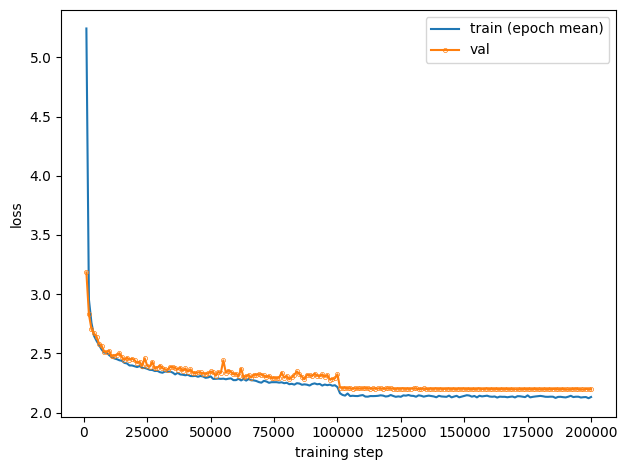

In [8]:
# showing training results

epoch_steps = np.arange(1, epochs+1) * steps_per_epoch

epoch_means = [
    float(np.mean(train_loss[i*steps_per_epoch:(i+1)*steps_per_epoch]))
    for i in range(epochs)
]

ti = int(np.argmin(epoch_means))   # index of min train loss (epoch-averaged)
vi = int(np.argmin(val_loss))      # index of min val loss (per epoch)

print("=== Loss summary ===")
print(f"Train — last: {epoch_means[-1]:.4f}  (epoch {epochs}, step {int(epoch_steps[-1])})")
print(f"Train —  min: {epoch_means[ti]:.4f}  (epoch {ti+1}, step {int(epoch_steps[ti])})")

print(f"Val   — last: {val_loss[-1]:.4f}     (epoch {len(val_loss)}, step {int(val_steps[-1])})")
print(f"Val   —  min: {val_loss[vi]:.4f}     (epoch {vi+1}, step {int(val_steps[vi])})")


plt.figure()
plt.plot(np.arange(1, epochs+1)*steps_per_epoch, epoch_means, label='train (epoch mean)')
plt.plot(val_steps, val_loss,
         marker='o', ms=3, mew=0.5, mfc='none', mec='auto', label='val')
plt.xlabel('training step'); plt.ylabel('loss'); plt.legend(); plt.tight_layout()
